In [28]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization, LSTM, Reshape
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# LSTM

### https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

# Read in Design Matrix

In [3]:
design_matrix = pd.read_csv("design_matrix.csv")

# Prepare

In [4]:
# Prepare for linear regression


# drop columns
cols_to_drop = ["cases", "deaths"]######, "FIPS"]

design_matrix_for_reg = design_matrix.drop(columns= cols_to_drop)

# Set fips to string to not be altered
design_matrix_for_reg["FIPS"] = design_matrix_for_reg["FIPS"].astype("str")
# DO NOT one-hot encode state
#design_matrix_for_reg = pd.get_dummies(design_matrix_for_reg, columns=["state"])

# fill na's with state mean for pollutants
design_matrix_for_reg[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]]  = \
    design_matrix[["state", "NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]].groupby(
    "state").transform(lambda x: x.fillna(x.mean())).reset_index()[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]]

# fill na's with no state with national mean from other readings
design_matrix_for_reg[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]] = \
design_matrix_for_reg[["NO2 AQI", "O3 AQI", "SO2 AQI", "CO AQI"]].fillna(design_matrix.mean())

# impute nan county vmt with jan_avg_vmt
design_matrix_for_reg.loc[
    design_matrix_for_reg.county_vmt.isna(), "county_vmt"] = \
design_matrix_for_reg["jan_avg_vmt"]

In [5]:
# drop na's
#####design_matrix_for_reg = pd.read_csv("design_matrix_for_linear_regression.csv")
design_matrix_lr = design_matrix_for_reg.dropna()

In [6]:
# drop columns
#print(design_matrix_lr.columns)
cols_to_drop = ["Unnamed: 0", "new_deaths"] #"Unnamed: 0.1"
design_matrix_lr = design_matrix_lr.drop(columns = cols_to_drop)

# Data Transformation

In [7]:
pop_feat_columns = ["population", "jan_avg_vmt", "county_vmt"]

pop_case_columns = ['new_cases_prev_5_days', 'new_deaths_prev_5_days',
       'new_cases_prev_7_days', 'new_deaths_prev_7_days',
       'new_cases_prev_14_days', 'new_deaths_prev_14_days']#"new_cases"

#np.log(design_matrix_lr.iloc[:,:-51] + 1).hist(figsize = (15, 20), xrot = 0.2);

# divide population columns by population (per person), take log to normalize distributions
des_mat = design_matrix_lr.copy()
# make it log (new cases per 100,000 people to be readable
#des_mat.loc[:, pop_case_columns] = np.log(des_mat.loc[:, pop_case_columns].divide(des_mat.loc[:, "population"], axis = "index") * 100000 + 1)
des_mat.loc[:, pop_feat_columns] = np.log(des_mat.loc[:, pop_feat_columns].divide(des_mat.loc[:, "population"], axis = "index") + 1)
#drop windowed columns, this time series model should figure it out
des_mat = des_mat.drop(columns=pop_case_columns)

# split
X = des_mat.drop(columns="new_cases")
y = des_mat["new_cases"]

# make u log (new case per 100,000 people + 1) to be readable, normalish, note skew
y = np.log(y.divide(design_matrix_lr.loc[:, "population"], axis = "index")*100000 + 1)


X = X.drop(columns="population")
# square root of cit accessibility
X["city_accessibility"] = np.sqrt(X.loc[:,"city_accessibility"])

#  drop rest of window columns
X = X.iloc[:, :20]
X = X.set_index(["FIPS", "date"])

# one-hot encode state
X = pd.get_dummies(X, columns=["state"])

# normalize X
X = (X - X.min())/(X.max() - X.min())

# normalize y
y = (y - y.min())/(y.max() - y.min())

# set y index to X index
y.index = X.index

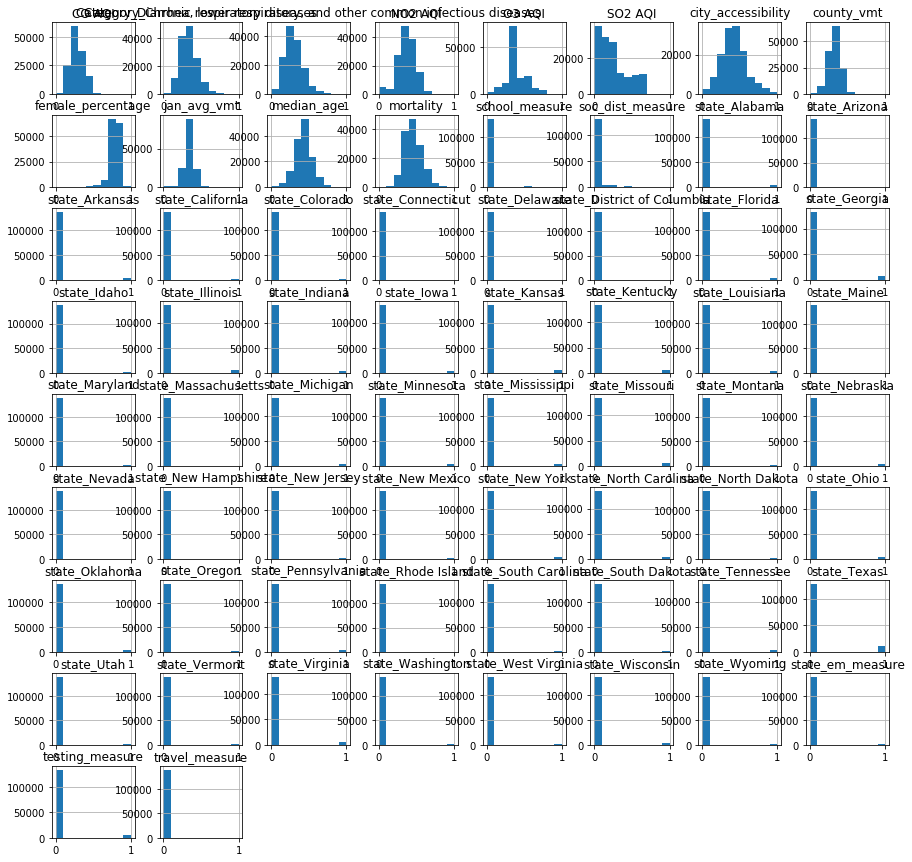

In [8]:
# Plot x-vals
X.hist(figsize=(15,15));

In [9]:
X.describe()

,median_age,female_percentage,city_accessibility,NO2 AQI,O3 AQI,SO2 AQI,CO AQI,jan_avg_vmt,county_vmt,"Category_Diarrhea, lower respiratory, and other common infectious diseases",...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
count,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,...,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000,140248.000000
mean,0.428282,0.784983,0.420506,0.372510,0.389171,0.248249,0.290537,0.346247,0.328437,0.301406,...,0.016086,0.031836,0.082105,0.008378,0.004692,0.044236,0.012735,0.018432,0.023794,0.007708
std,0.113844,0.062661,0.166816,0.120870,0.130821,0.191140,0.103429,0.064924,0.082128,0.127518,...,0.125806,0.175565,0.274525,0.091148,0.068335,0.205620,0.112127,0.134507,0.152406,0.087455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.359823,0.771878,0.309043,0.284440,0.316443,0.098520,0.225183,0.310187,0.274914,0.214618,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.428256,0.796903,0.411136,0.370687,0.362827,0.219323,0.273533,0.349503,0.330978,0.287339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.494481,0.815936,0.515532,0.455451,0.472699,0.356129,0.346349,0.385246,0.383803,0.371774,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


count    140248.000000
mean          0.059324
std           0.124852
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

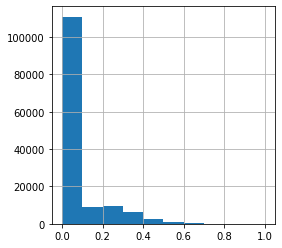

In [11]:
# plot y_vals
y.hist(figsize = (4,4));
y.describe()

# Modeling

In [12]:
batch_size = 47
# Yay, each batch size is 47, number of days we have data
X.reset_index().groupby("FIPS").count()["date"].unique()

array([47])

In [13]:
# train test split by FIPS
fips_train, fips_test = train_test_split(X.reset_index()["FIPS"].unique(), test_size = 0.1, random_state = 98)

X_train = X.loc[X.index.get_level_values(0).isin(fips_train), :].values
X_test = X.loc[X.index.get_level_values(0).isin(fips_test), :].values

y_train = y.loc[y.index.get_level_values(0).isin(fips_train), :].values
y_test = y.loc[y.index.get_level_values(0).isin(fips_test), :].values

In [14]:
X_train.shape

(126195, 66)

In [16]:
y_train.shape

(126195,)

In [36]:
def build_lstm_model(cols, X_train, y_train, X_test, y_test):
    
    # Extract subset of data for modeling
    X_train_sub = X_train[:,cols]
    X_test_sub = X_test[cols]
    
    # reshape input to be 3D [samples, timesteps, features]
    #reshape data for model
    X_tr_re = X_train_sub.reshape(-1, batch_size,X_train_sub.shape[1])
    y_tr_re = y_train.reshape(-1, batch_size, 1)

    # reshape data for model
    X_te_re = X_test.reshape(-1, batch_size,X_test.shape[1])
    y_te_re = y_test.reshape(-1, batch_size, 1)
    #print(X_tr_re.shape)
    print("\033[1mFeatures being used:\033[0m {}".format(X.columns[cols].values))
    print()
    
    # configure network
    #n_batch = len(X)
    n_epoch = 5
    n_neurons = 40
    # design network
    model = Sequential()
    model.add(Reshape(target_shape=((X_tr_re.shape[1], X_tr_re.shape[2]))))
    model.add(Dropout(0.2))
    model.add(LSTM(n_neurons, input_shape=(X_tr_re.shape[1], X_tr_re.shape[2]))), #stateful=True)))

    # use relu to bind to realistic bounds, new cases >= 0
    model.add(Dense(47, activation="relu"))
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    model_history = model.fit(X_tr_re, y_tr_re, epochs=n_epoch, batch_size=1, verbose=1, shuffle=True, validation_split = 0.2)
    #model.reset_states()
    print(model.summary())
    return model, model_history

In [37]:
# Baseline
cols = [X.columns.get_loc(col) for col in X.columns]
base_hist, base_mod = build_lstm_model(cols, X_train, y_train, X_test, y_test)

Features being used: ['median_age' 'female_percentage' 'city_accessibility' 'NO2 AQI' 'O3 AQI'
 'SO2 AQI' 'CO AQI' 'jan_avg_vmt' 'county_vmt'
 'Category_Diarrhea, lower respiratory, and other common infectious diseases'
 'Category_Chronic respiratory diseases' 'mortality' 'travel_measure'
 'school_measure' 'soc_dist_measure' 'state_em_measure' 'testing_measure'
 'state_Alabama' 'state_Arizona' 'state_Arkansas' 'state_California'
 'state_Colorado' 'state_Connecticut' 'state_Delaware'
 'state_District of Columbia' 'state_Florida' 'state_Georgia'
 'state_Idaho' 'state_Illinois' 'state_Indiana' 'state_Iowa'
 'state_Kansas' 'state_Kentucky' 'state_Louisiana' 'state_Maine'
 'state_Maryland' 'state_Massachusetts' 'state_Michigan' 'state_Minnesota'
 'state_Mississippi' 'state_Missouri' 'state_Montana' 'state_Nebraska'
 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Or

In [38]:
# Trivial Example no data*
triv_cols = [X.columns.get_loc(X.columns[-1])]
triv_hist, triv_mod = build_lstm_model(triv_cols, X_train, y_train, X_test, y_test)

Features being used: ['state_Wyoming']

Train on 2148 samples, validate on 537 samples
Epoch 1/5
2148/2148 [==============================] - 18s 8ms/sample - loss: 0.0207 - val_loss: 0.0126
Epoch 2/5
2148/2148 [==============================] - 16s 7ms/sample - loss: 0.0207 - val_loss: 0.0126
Epoch 3/5
2148/2148 [==============================] - 16s 7ms/sample - loss: 0.0207 - val_loss: 0.0126
Epoch 4/5
2148/2148 [==============================] - 16s 7ms/sample - loss: 0.0207 - val_loss: 0.0126
Epoch 5/5
2148/2148 [==============================] - 16s 7ms/sample - loss: 0.0207 - val_loss: 0.0126
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
________________________________________

In [39]:
# State indicators not being used
stateless_cols = [X.columns.get_loc(col) for col in X.columns[:-49]]
stateless_hist, stateless_mod = build_lstm_model(stateless_cols, X_train, y_train, X_test, y_test)

Features being used: ['median_age' 'female_percentage' 'city_accessibility' 'NO2 AQI' 'O3 AQI'
 'SO2 AQI' 'CO AQI' 'jan_avg_vmt' 'county_vmt'
 'Category_Diarrhea, lower respiratory, and other common infectious diseases'
 'Category_Chronic respiratory diseases' 'mortality' 'travel_measure'
 'school_measure' 'soc_dist_measure' 'state_em_measure' 'testing_measure']

Train on 2148 samples, validate on 537 samples
Epoch 1/5
2148/2148 [==============================] - 19s 9ms/sample - loss: 0.0147 - val_loss: 0.0112
Epoch 2/5
2148/2148 [==============================] - 16s 8ms/sample - loss: 0.0139 - val_loss: 0.0108
Epoch 3/5
2148/2148 [==============================] - 16s 8ms/sample - loss: 0.0136 - val_loss: 0.0112
Epoch 4/5
2148/2148 [==============================] - 16s 8ms/sample - loss: 0.0131 - val_loss: 0.0099
Epoch 5/5
2148/2148 [==============================] - 16s 8ms/sample - loss: 0.0130 - val_loss: 0.0104
Model: "sequential_13"
____________________________________________

In [40]:
# AQI indicators not being used
aqis = ['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']
non_aqis = np.setdiff1d(list(X.columns), list(aqis))
aqi_cols = [X.columns.get_loc(col) for col in non_aqis]
aqi_hist, aqi_mod = build_lstm_model(aqi_cols, X_train, y_train, X_test, y_test)

Features being used: ['Category_Chronic respiratory diseases'
 'Category_Diarrhea, lower respiratory, and other common infectious diseases'
 'city_accessibility' 'county_vmt' 'female_percentage' 'jan_avg_vmt'
 'median_age' 'mortality' 'school_measure' 'soc_dist_measure'
 'state_Alabama' 'state_Arizona' 'state_Arkansas' 'state_California'
 'state_Colorado' 'state_Connecticut' 'state_Delaware'
 'state_District of Columbia' 'state_Florida' 'state_Georgia'
 'state_Idaho' 'state_Illinois' 'state_Indiana' 'state_Iowa'
 'state_Kansas' 'state_Kentucky' 'state_Louisiana' 'state_Maine'
 'state_Maryland' 'state_Massachusetts' 'state_Michigan' 'state_Minnesota'
 'state_Mississippi' 'state_Missouri' 'state_Montana' 'state_Nebraska'
 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Oregon'
 'state_Pennsylvania' 'state_Rhode Island' 'state_South Carolina'
 'state_South Dakota'

In [41]:
# vmt indicators not being used
vmts = ['jan_avg_vmt' 'county_vmt']
non_vmts = np.setdiff1d(list(X.columns), list(vmts))
vmt_cols = [X.columns.get_loc(col) for col in non_vmts]
vmt_hist, vmt_mod = build_lstm_model(vmt_cols, X_train, y_train, X_test, y_test)

Features being used: ['CO AQI' 'Category_Chronic respiratory diseases'
 'Category_Diarrhea, lower respiratory, and other common infectious diseases'
 'NO2 AQI' 'O3 AQI' 'SO2 AQI' 'city_accessibility' 'county_vmt'
 'female_percentage' 'jan_avg_vmt' 'median_age' 'mortality'
 'school_measure' 'soc_dist_measure' 'state_Alabama' 'state_Arizona'
 'state_Arkansas' 'state_California' 'state_Colorado' 'state_Connecticut'
 'state_Delaware' 'state_District of Columbia' 'state_Florida'
 'state_Georgia' 'state_Idaho' 'state_Illinois' 'state_Indiana'
 'state_Iowa' 'state_Kansas' 'state_Kentucky' 'state_Louisiana'
 'state_Maine' 'state_Maryland' 'state_Massachusetts' 'state_Michigan'
 'state_Minnesota' 'state_Mississippi' 'state_Missouri' 'state_Montana'
 'state_Nebraska' 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Oregon'
 'state_Pennsylvania' 'state_Rhode Island' 'state

In [42]:
# mortality
mortality_cols = ['Category_Diarrhea, lower respiratory, and other common infectious diseases',
 'Category_Chronic respiratory diseases', 'mortality']
non_mort = np.setdiff1d(list(X.columns), list(mortality_cols))
mort_cols = [X.columns.get_loc(col) for col in non_mort]
mort_hist, mort_mod = build_lstm_model(mort_cols, X_train, y_train, X_test, y_test)

Features being used: ['CO AQI' 'NO2 AQI' 'O3 AQI' 'SO2 AQI' 'city_accessibility' 'county_vmt'
 'female_percentage' 'jan_avg_vmt' 'median_age' 'school_measure'
 'soc_dist_measure' 'state_Alabama' 'state_Arizona' 'state_Arkansas'
 'state_California' 'state_Colorado' 'state_Connecticut' 'state_Delaware'
 'state_District of Columbia' 'state_Florida' 'state_Georgia'
 'state_Idaho' 'state_Illinois' 'state_Indiana' 'state_Iowa'
 'state_Kansas' 'state_Kentucky' 'state_Louisiana' 'state_Maine'
 'state_Maryland' 'state_Massachusetts' 'state_Michigan' 'state_Minnesota'
 'state_Mississippi' 'state_Missouri' 'state_Montana' 'state_Nebraska'
 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Oregon'
 'state_Pennsylvania' 'state_Rhode Island' 'state_South Carolina'
 'state_South Dakota' 'state_Tennessee' 'state_Texas' 'state_Utah'
 'state_Vermont' 'state_Virginia' 'state_Washin

In [43]:
# measures
measure_cols = ['travel_measure', 'school_measure', 'soc_dist_measure', 'state_em_measure', 'testing_measure']
non_meas = np.setdiff1d(list(X.columns), list(measure_cols))
meas_cols = [X.columns.get_loc(col) for col in non_meas]
meas_hist, meas_mod = build_lstm_model(meas_cols, X_train, y_train, X_test, y_test)

Features being used: ['CO AQI' 'Category_Chronic respiratory diseases'
 'Category_Diarrhea, lower respiratory, and other common infectious diseases'
 'NO2 AQI' 'O3 AQI' 'SO2 AQI' 'city_accessibility' 'county_vmt'
 'female_percentage' 'jan_avg_vmt' 'median_age' 'mortality'
 'state_Alabama' 'state_Arizona' 'state_Arkansas' 'state_California'
 'state_Colorado' 'state_Connecticut' 'state_Delaware'
 'state_District of Columbia' 'state_Florida' 'state_Georgia'
 'state_Idaho' 'state_Illinois' 'state_Indiana' 'state_Iowa'
 'state_Kansas' 'state_Kentucky' 'state_Louisiana' 'state_Maine'
 'state_Maryland' 'state_Massachusetts' 'state_Michigan' 'state_Minnesota'
 'state_Mississippi' 'state_Missouri' 'state_Montana' 'state_Nebraska'
 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Oregon'
 'state_Pennsylvania' 'state_Rhode Island' 'state_South Carolina'
 'state_South Dakot

In [44]:
# demographics
dem_cols = ['median_age' 'female_percentage' 'city_accessibility']
non_dems = np.setdiff1d(list(X.columns), list(dem_cols))
demo_cols = [X.columns.get_loc(col) for col in non_dems]
demo_hist, demo_mod = build_lstm_model(demo_cols, X_train, y_train, X_test, y_test)

Features being used: ['CO AQI' 'Category_Chronic respiratory diseases'
 'Category_Diarrhea, lower respiratory, and other common infectious diseases'
 'NO2 AQI' 'O3 AQI' 'SO2 AQI' 'city_accessibility' 'county_vmt'
 'female_percentage' 'jan_avg_vmt' 'median_age' 'mortality'
 'school_measure' 'soc_dist_measure' 'state_Alabama' 'state_Arizona'
 'state_Arkansas' 'state_California' 'state_Colorado' 'state_Connecticut'
 'state_Delaware' 'state_District of Columbia' 'state_Florida'
 'state_Georgia' 'state_Idaho' 'state_Illinois' 'state_Indiana'
 'state_Iowa' 'state_Kansas' 'state_Kentucky' 'state_Louisiana'
 'state_Maine' 'state_Maryland' 'state_Massachusetts' 'state_Michigan'
 'state_Minnesota' 'state_Mississippi' 'state_Missouri' 'state_Montana'
 'state_Nebraska' 'state_Nevada' 'state_New Hampshire' 'state_New Jersey'
 'state_New Mexico' 'state_New York' 'state_North Carolina'
 'state_North Dakota' 'state_Ohio' 'state_Oklahoma' 'state_Oregon'
 'state_Pennsylvania' 'state_Rhode Island' 'state

In [45]:
# Note, all columns for history and mod are currently switched

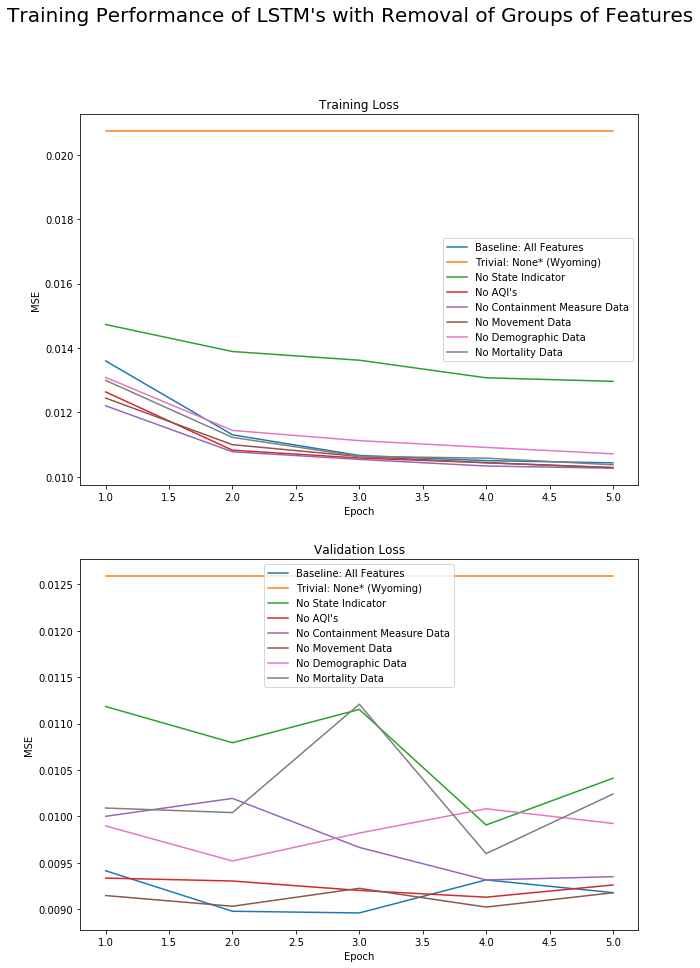

In [46]:
fig, ax = plt.subplots(2,1, figsize=(10,15))
    
x_vals = range(1, 6)

# baseline
# train loss
ax[0].plot(x_vals, base_mod.history['loss'], label = "Baseline: All Features")
# val loss
ax[1].plot(x_vals, base_mod.history['val_loss'], label = "Baseline: All Features")
                       
# trivial
# train loss
ax[0].plot(x_vals, triv_mod.history['loss'], label = "Trivial: None* (Wyoming)")
# val loss
ax[1].plot(x_vals, triv_mod.history['val_loss'], label = "Trivial: None* (Wyoming)")

# stateless
# train loss
ax[0].plot(x_vals, stateless_mod.history['loss'], label = "No State Indicator")
# val loss
ax[1].plot(x_vals, stateless_mod.history['val_loss'], label = "No State Indicator")

# aqi-less
# train loss
ax[0].plot(x_vals, aqi_mod.history['loss'], label = "No AQI's")
# val loss
ax[1].plot(x_vals, aqi_mod.history['val_loss'], label = "No AQI's")

# Containment Measures
# train loss
ax[0].plot(x_vals, meas_mod.history['loss'], label = "No Containment Measure Data")
# val loss
ax[1].plot(x_vals, meas_mod.history['val_loss'], label = "No Containment Measure Data")

# Movement Data
# train loss
ax[0].plot(x_vals, vmt_mod.history['loss'], label = "No Movement Data")
# val loss
ax[1].plot(x_vals, vmt_mod.history['val_loss'], label = "No Movement Data")

# Demographic Data
# train loss
ax[0].plot(x_vals, demo_mod.history['loss'], label = "No Demographic Data")
# val loss
ax[1].plot(x_vals, demo_mod.history['val_loss'], label = "No Demographic Data")

# Mortality Data
# train loss
ax[0].plot(x_vals, mort_mod.history['loss'], label = "No Mortality Data")
# val loss
ax[1].plot(x_vals, mort_mod.history['val_loss'], label = "No Mortality Data")

# Set labels
ax[0].set_title("Training Loss")
ax[0].set_ylabel("MSE")
ax[0].set_xlabel("Epoch")
ax[0].legend()

# Set labels
ax[1].set_title("Validation Loss")
ax[1].set_ylabel("MSE")
ax[1].set_xlabel("Epoch")
ax[1].legend()

fig.suptitle("Training Performance of LSTM's with Removal of Groups of Features", fontsize=20);

In [47]:
def run_predict(mod, cols, X_train, y_train, X_test, y_test):
    
    # Extract subset of data for modeling
    X_train_sub = X_train[:,cols]
    X_test_sub = X_test[:,cols]
    
    # reshape input to be 3D [samples, timesteps, features]
    #reshape data for model
    X_tr_re = X_train_sub.reshape(-1, batch_size,X_train_sub.shape[1])
    y_tr_re = y_train.reshape(-1, batch_size, 1)

    # reshape data for model
    X_te_re = X_test_sub.reshape(-1, batch_size,X_test_sub.shape[1])
    y_te_re = y_test.reshape(-1, batch_size, 1)
    
    # batch forecast
    yhat = mod.predict(X_te_re, batch_size=1)
    # Print output
    #for batch, y in enumerate(yhat):
    #    for i in range(47):
    #        print('>Expected=%.3f, Predicted=%.3f' % (y_te_re[batch,i], y[i]))
    #    print()
    return yhat

In [48]:
y_te_re.shape#_preds.shape

NameError: name 'y_te_re' is not defined

In [51]:
# Print Test MSE's

base_preds = run_predict(base_hist, cols, X_train, y_train, X_test, y_test)
print("\033[1mBaseline Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = base_preds.flatten())))

triv_preds = run_predict(triv_hist, triv_cols, X_train, y_train, X_test, y_test)
print("\033[1mTrivial Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = triv_preds.flatten())))

mort_preds = run_predict(mort_hist, mort_cols, X_train, y_train, X_test, y_test)
print("\033[1mMortality-Less Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = mort_preds.flatten())))

vmt_preds = run_predict(vmt_hist, vmt_cols, X_train, y_train, X_test, y_test)
print("\033[1mMovement-Less Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = vmt_preds.flatten())))

demo_preds = run_predict(demo_hist, demo_cols, X_train, y_train, X_test, y_test)
print("\033[1mDemographic-Less Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = demo_preds.flatten())))

aqi_preds = run_predict(aqi_hist, aqi_cols, X_train, y_train, X_test, y_test)
print("\033[1mAQI-Less Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = aqi_preds.flatten())))

meas_preds = run_predict(meas_hist, meas_cols, X_train, y_train, X_test, y_test)
print("\033[1mMeasure-Less Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = meas_preds.flatten())))

state_preds = run_predict(stateless_hist, stateless_cols, X_train, y_train, X_test, y_test)
print("\033[1mState-Less Test MSE:\033[0m {:.4f}".format(mean_squared_error(y_true = y_te_re.flatten(), y_pred = state_preds.flatten())))


Baseline Test MSE: 0.0095
Trivial Test MSE: 0.0193
Mortality-Less Test MSE: 0.0096
Movement-Less Test MSE: 0.0093
Demographic-Less Test MSE: 0.0100
AQI-Less Test MSE: 0.0095
Measure-Less Test MSE: 0.0095
State-Less Test MSE: 0.0120


In [50]:
# reshape input to be 3D [samples, timesteps, features]
#reshape data for model
X_tr_re = X_train.reshape(-1, batch_size,X_train.shape[1])
y_tr_re = y_train.reshape(-1, batch_size, 1)

# reshape data for model
X_te_re = X_test.reshape(-1, batch_size,X_test.shape[1])
y_te_re = y_test.reshape(-1, batch_size, 1)

In [174]:
# configure network
#n_batch = len(X)
n_epoch = 10
n_neurons = 40
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(1, X_tr_re.shape[1], X_tr_re.shape[2]), stateful=True))

# use relu to bind to realistic bounds, new cases >= 0
model.add(Dense(47, activation="relu"))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
for i in range(n_epoch):
    model.fit(X_tr_re, y_tr_re, epochs=1, batch_size=1, verbose=1, shuffle=False, validation_split = 0.2)
    model.reset_states()


Train on 2148 samples, validate on 537 samples
2148/2148 [==============================] - 19s 9ms/sample - loss: 0.0131 - val_loss: 0.0111
Train on 2148 samples, validate on 537 samples
2148/2148 [==============================] - 17s 8ms/sample - loss: 0.0108 - val_loss: 0.0104
Train on 2148 samples, validate on 537 samples
2148/2148 [==============================] - 17s 8ms/sample - loss: 0.0105 - val_loss: 0.0101
Train on 2148 samples, validate on 537 samples
2148/2148 [==============================] - 17s 8ms/sample - loss: 0.0103 - val_loss: 0.0101
Train on 2148 samples, validate on 537 samples
2148/2148 [==============================] - 17s 8ms/sample - loss: 0.0102 - val_loss: 0.0101


In [169]:
y.shape

(47,)

In [176]:
# batch forecast
yhat = model.predict(X_te_re, batch_size=1)
for batch, y in enumerate(yhat):
    for i in range(47):
        print('>Expected=%.3f, Predicted=%.3f' % (y_te_re[batch,i], y[i]))
    print()

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.034
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.088
>Expected=0.000, Predicted=0.145
>Expected=0.000, Predicted=0.087
>Expected=0.000, Predicted=0.100
>Expected=0.000, Predicted=0.107
>Expected=0.342, Predicted=0.057
>Expected=0.253, Predicted=0.136
>Expected=

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.022
>Expected=0.000, Predicted=0.043
>Expected=0.000, Predicted=0.040
>Expected=0.000, Predicted=0.068
>Expected=0.000, Predicted=0.094
>Expected=0.000, Predicted=0.058
>Expected=0.000, Predicted=0.127
>Expected=0.000, Predicted=0.136
>Expected=0.000, Predicted=0.135
>Expected=0.000, Predicted=0.129
>Expected=0.000, Predicted=0.103
>Expected=0.000, Predicted=0.126
>Expected=0.369, Predicted=0.170
>Expected=0.277, Predicted=0.221
>Expected=0.369, Predicted=0.140
>Expected=0.277, Predicted=0.132
>Expected=0.000, Predicted=0.172
>Expected=0.277, Predicted=0.144
>Expected=0.277, Predicted=0.105
>Expected=0.425, Predicted=0.136
>Expected=0.277, Predicted=0.188
>Expected=0.277, Predicted=0.125
>Expected=0.369, Predicted=0.184
>Expected=0.277, Predicted=0.199

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.201, Predicted=0.027
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.034
>Expected=0.000, Predicted=0.051
>Expected=0.000, Predicted=0.063
>Expected=0.000, Predicted=0.064
>Expected=0.000, Predicted=0.061
>Expected=0.000, Predicted=0.059
>Expected=0.000, Predicted=0.067
>Expected=0.000, Predicted=0.094
>Expected=0.000, Predicted=0.104
>Expected=

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.045
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.085
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.193, Predicted=0.081
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.136
>Expected=0.000, Predicted=0.172
>Expected=0.000, Predicted=0.154
>Expected=0.000, Predicted=0.177
>Expected=0.000, Predicted=0.205
>Expected=0.000, Predicted=0.179
>Expected=0.193, Predicted=0.189
>Expected=0.000, Predicted=0.200
>Expected=0.000, Predicted=0.252
>Expected=0.000, Predicted=0.213
>Expected=0.000, Predicted=0.174
>Expected=0.193, Predicted=0.226
>Expected=0.000, Predicted=0.176
>Expected=0.000, Predicted=0.220
>Expected=0.000, Predicted=0.183
>Expected=0.000, Predicted=0.182
>Expected=

>Expected=0.000, Predicted=0.065

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.015
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.031
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.050
>Expected

>Expected=0.000, Predicted=0.067
>Expected=0.000, Predicted=0.096
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.054
>Expected=0.000, Predicted=0.050
>Expected=0.000, Predicted=0.011
>Expected=0.000, Predicted=0.007
>Expected=0.000, Predicted=0.062
>Expected=0.000, Predicted=0.041
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.069
>Expected=0.000, Predicted=0.000

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected

>Expected=0.000, Predicted=0.023
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.011
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.002
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.005
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected

>Expected=0.000, Predicted=0.109
>Expected=0.000, Predicted=0.031
>Expected=0.000, Predicted=0.013
>Expected=0.000, Predicted=0.051
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.050
>Expected=0.000, Predicted=0.022
>Expected=0.000, Predicted=0.100
>Expected=0.000, Predicted=0.057
>Expected=0.000, Predicted=0.078
>Expected=0.000, Predicted=0.043

>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected=0.000, Predicted=0.000
>Expected

>Expected=0.000, Predicted=0.053
>Expected=0.248, Predicted=0.000
>Expected=0.000, Predicted=0.065
>Expected=0.000, Predicted=0.000
>Expected=0.170, Predicted=0.000
>Expected=0.000, Predicted=0.093
>Expected=0.170, Predicted=0.000
>Expected=0.170, Predicted=0.112
>Expected=0.299, Predicted=0.156
>Expected=0.248, Predicted=0.116
>Expected=0.170, Predicted=0.213
>Expected=0.000, Predicted=0.206
>Expected=0.170, Predicted=0.194
>Expected=0.170, Predicted=0.207
>Expected=0.248, Predicted=0.237
>Expected=0.170, Predicted=0.296
>Expected=0.000, Predicted=0.199
>Expected=0.337, Predicted=0.233
>Expected=0.248, Predicted=0.237
>Expected=0.000, Predicted=0.229
>Expected=0.170, Predicted=0.239
>Expected=0.000, Predicted=0.161
>Expected=0.337, Predicted=0.204
>Expected=0.170, Predicted=0.248
>Expected=0.299, Predicted=0.258
>Expected=0.000, Predicted=0.185
>Expected=0.248, Predicted=0.133
>Expected=0.299, Predicted=0.172
>Expected=0.248, Predicted=0.238
>Expected=0.000, Predicted=0.207
>Expected=